In [120]:
import pandas as pd
from scipy.special import softmax
from tqdm import tqdm
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.backends.backend_pdf import PdfPages
from loguru import logger

In [2]:
annotations = pd.read_pickle('../data/epic-kitchens-100-annotations/EPIC_100_validation.pkl')
verbs = pd.read_csv('../data/epic-kitchens-100-annotations/EPIC_100_verb_classes.csv', index_col=0)
nouns = pd.read_csv('../data/epic-kitchens-100-annotations/EPIC_100_noun_classes.csv', index_col=0)

In [3]:
asf_df = pd.read_pickle("../audio-cm.pkl")
asf_gru_df = pd.read_pickle("../audio-cm.pkl")
sf_df = pd.read_pickle("../visu-cm.pkl")

In [127]:
asf_verb_logits = {id_: softmax(output) for id_, output in zip(asf_df["narration_id"], asf_df["verb_output"])}
asf_noun_logits = {id_: softmax(output) for id_, output in zip(asf_df["narration_id"], asf_df["noun_output"])}
sf_verb_logits = {id_: softmax(output) for id_, output in zip(sf_df["narration_id"], sf_df["verb_output"])}
sf_noun_logits = {id_: softmax(output) for id_, output in zip(sf_df["narration_id"], sf_df["noun_output"])}
asf_gru_verb_logits = {id_: softmax(output) for id_, output in zip(asf_gru_df["narration_id"], asf_gru_df["verb_output"])}
asf_gru_noun_logits = {id_: softmax(output) for id_, output in zip(asf_gru_df["narration_id"], asf_gru_df["noun_output"])}


ensemble_verb_logits = {id_: softmax(o1 + o2) for id_, o1, o2 in zip(asf_gru_df["narration_id"], asf_gru_df["verb_output"], sf_df["verb_output"])}
ensemble_noun_logits = {id_: softmax(o1 + o2) for id_, o1, o2 in zip(asf_gru_df["narration_id"], asf_gru_df["noun_output"], sf_df["noun_output"])}

In [108]:
# Set up seaborn

# Configure matplotlib to use LaTeX for rendering text
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

# Tabluate probas of each class separately, for all verbs/nouns

In [129]:
all_verbs = annotations["verb_class"].unique()

output_dir = "../res/anova/verbs"
os.makedirs(output_dir, exist_ok=True)

for verb_class in tqdm(all_verbs):
    class_name = verbs.loc[verb_class, "key"]
    class_df = annotations.loc[annotations["verb_class"] == verb_class][["narration", "verb", "verb_class", "noun", "noun_class", "all_nouns"]].copy()
    corresponding_ids = class_df.index
    class_df["asf_prob"] = [asf_verb_logits[id_][verb_class] for id_ in corresponding_ids]
    class_df["sf_prob"] = [sf_verb_logits[id_][verb_class] for id_ in corresponding_ids]
    class_df["asf_gru_prob"] = [asf_gru_verb_logits[id_][verb_class] for id_ in corresponding_ids]
    class_df["ensemble_prob"] = [ensemble_verb_logits[id_][verb_class] for id_ in corresponding_ids]

    if class_df.empty:
        logger.warning(f"Verb class {class_name} is empty, skipping")
        continue

    if class_df[class_df["asf_prob"] > 0.5].shape[0] > 0 or class_df[class_df["asf_gru_prob"] > 0.5].shape[0] > 0:
        logger.success(f"Verb class {class_name} has high confidence")

    class_df.to_pickle(os.path.join(output_dir, f"{verbs.loc[verb_class, 'key']}.pkl"))

    # Plotting
    melted_df = pd.melt(
        class_df,
        value_vars=["asf_prob", "sf_prob", "asf_gru_prob", "ensemble_prob"],
        var_name="Condition",
        value_name="Probability",
    )
    # Update the 'Condition' column to have more descriptive names for the legend
    melted_df["Model"] = melted_df["Condition"].map(
        {
            # "asf_prob": "AudioSlowFast",
            "asf_gru_prob": "AudioSlowFastGRU",
            "sf_prob": "SlowFast",
            "ensemble_prob": "MMLate-SlowFastGRU",
        }
    )

    # Create the plot
    sns.histplot(
        data=melted_df,
        x="Probability",
        hue="Model",
        kde=True,
        bins=20,
        element="step",  # Using 'step' to better distinguish overlapping groups
    )
    sns.despine()

    # Format x-axis ticks as percentages
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

    styled_verb_name = r"\texttt{" + class_name + r"}"
    plt.title(f"Model confidence on verb {styled_verb_name}", fontsize=12)

    plt.xlim(0, 1)

    # Improve figure quality by adjusting figure size and DPI
    plt.gcf().set_size_inches(5, 4)
    plt.gcf().dpi = 300.0

    # # Show the plot
    # plt.show()

    # Save the plot to a PDF file
    pdf_path = os.path.join(output_dir, f"dist_{class_name}.pdf")
    with PdfPages(pdf_path) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

100%|██████████| 78/78 [00:21<00:00,  3.65it/s]


In [125]:
all_nouns = annotations["noun_class"].unique()

output_dir = "../res/anova/nouns"
os.makedirs(output_dir, exist_ok=True)

for noun_class in tqdm(all_nouns):
    class_name = nouns.loc[noun_class, "key"]
    class_df = annotations.loc[annotations["noun_class"] == noun_class][
        ["narration", "verb", "verb_class", "noun", "noun_class", "all_nouns"]
    ].copy()
    corresponding_ids = class_df.index
    class_df["asf_prob"] = [asf_noun_logits[id_][noun_class] for id_ in corresponding_ids]
    class_df["sf_prob"] = [sf_noun_logits[id_][noun_class] for id_ in corresponding_ids]
    class_df["asf_gru_prob"] = [asf_gru_noun_logits[id_][noun_class] for id_ in corresponding_ids]
    class_df["ensemble_prob"] = [ensemble_noun_logits[id_][noun_class] for id_ in corresponding_ids]

    if class_df[class_df["asf_prob"] > 0.5].shape[0] > 0 or class_df[class_df["asf_gru_prob"] > 0.5].shape[0] > 0:
        logger.success(f"Noun class {class_name} has high confidence")

    class_df.to_pickle(os.path.join(output_dir, f"{nouns.loc[noun_class, 'key']}.pkl"))

    # Plotting
    melted_df = pd.melt(
        class_df,
        value_vars=["asf_prob", "sf_prob", "asf_gru_prob"],
        var_name="Condition",
        value_name="Probability",
    )
    # Update the 'Condition' column to have more descriptive names for the legend
    melted_df["Model"] = melted_df["Condition"].map(
        {
            # "asf_prob": "AudioSlowFast",
            "asf_gru_prob": "AudioSlowFastGRU",
            "sf_prob": "SlowFast",
            "ensemble_prob": "MMLate-SlowFastGRU",
        }
    )

    # Create the plot
    sns.histplot(
        data=melted_df,
        x="Probability",
        hue="Model",
        kde=True,
        bins=20,
        element="step",  # Using 'step' to better distinguish overlapping groups
    )
    sns.despine()

    # Format x-axis ticks as percentages
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    plt.xlim(0, 1)

    styled_verb_name = r"\texttt{" + class_name + r"}"
    plt.title(f"Model confidence on noun {styled_verb_name}", fontsize=12)

    # Improve figure quality by adjusting figure size and DPI
    plt.gcf().set_size_inches(5, 4)
    plt.gcf().dpi = 300.0

    # # Show the plot
    # plt.show()

    # Save the plot to a PDF file
    pdf_path = os.path.join(output_dir, f"dist_{class_name}.pdf")
    with PdfPages(pdf_path) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

100%|██████████| 211/211 [00:53<00:00,  3.98it/s]


# Compute $2$-way ANOVA

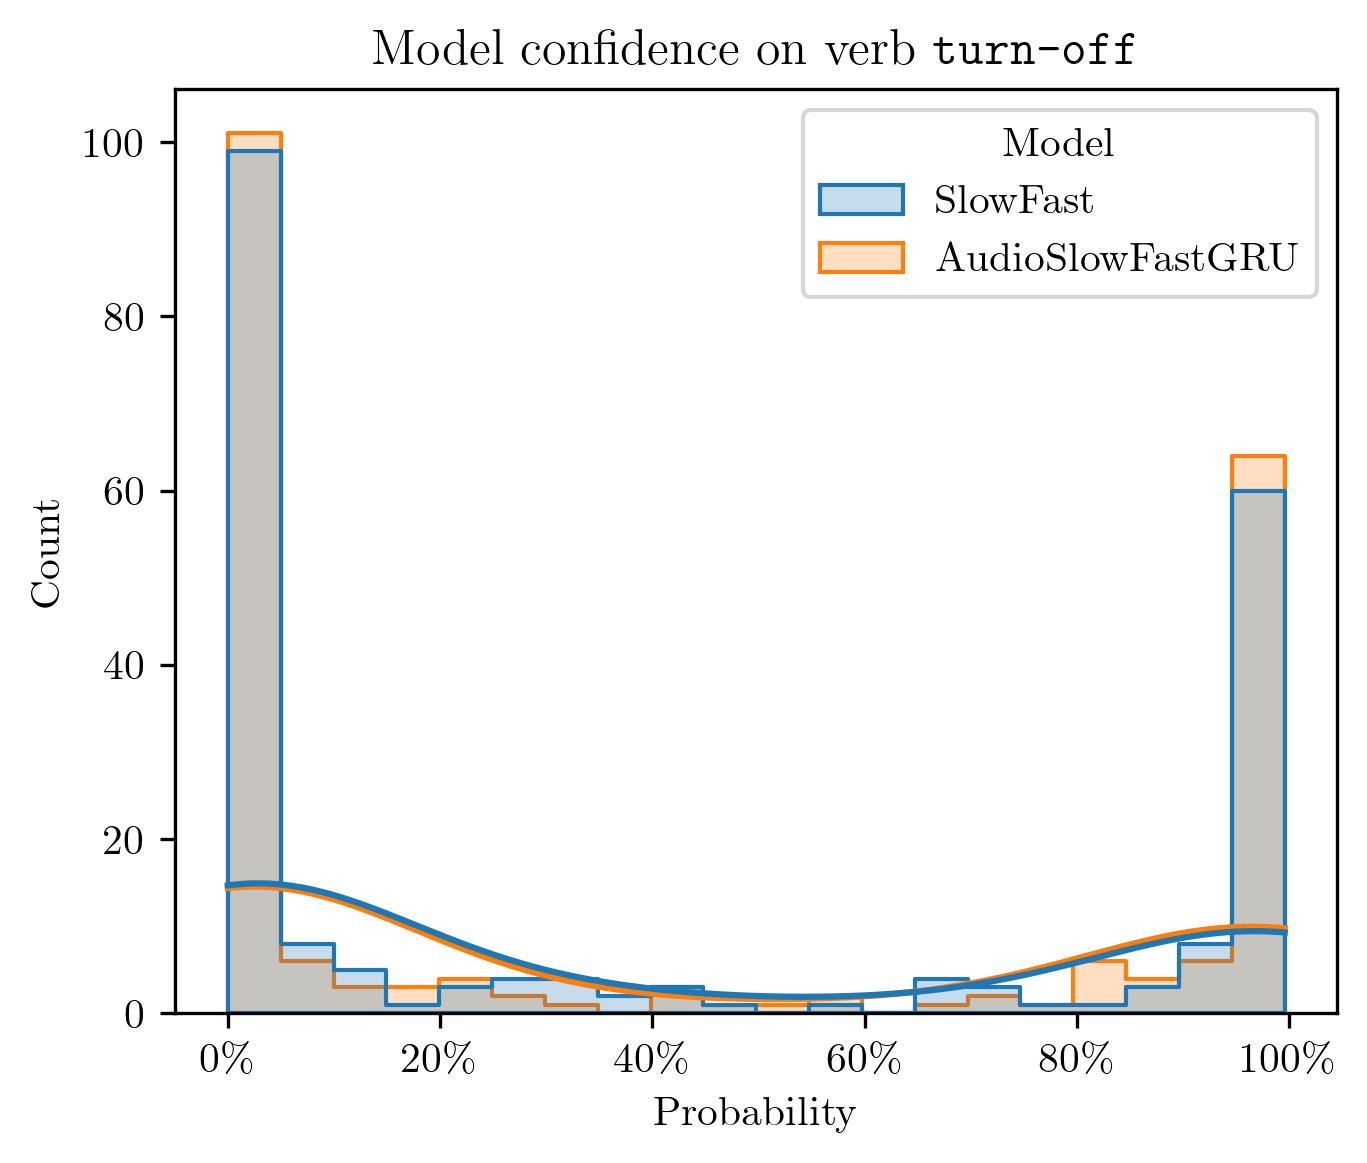

In [107]:
# Assuming 'verb_class_df' is your original DataFrame
# Reshape the DataFrame


In [ ]:
verb_class_df.anova(dv="c", between="verb", detailed=True)

In [7]:
import time
from datetime import timedelta


def timestamp_to_sec(timestamp):
    x = time.strptime(timestamp, "%H:%M:%S.%f")
    sec = (
        float(timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds())
        + float(timestamp.split(".")[-1]) / 100
    )
    return sec


annotations["duration"] = annotations["stop_timestamp"].apply(timestamp_to_sec) - annotations["start_timestamp"].apply(timestamp_to_sec)

In [13]:
annotations.loc[annotations["duration"] > 2.0].shape[0] / annotations.shape[0]

0.4864501448076127